In [1]:
from IPython.display import display, Markdown, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import math
import ROOT
import numpy as np, pandas as pd
import yaml
import base64
import ctypes
import logging

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import output_file

from RootInteractive.InteractiveDrawing.bokeh.bokehDrawSA import *
from RootInteractive.InteractiveDrawing.bokeh.bokehTools import bokehDrawArray
from RootInteractive.Tools.pandaTools import initMetadata
from RootInteractive.Tools.aliTreePlayer import *

output_notebook()

Welcome to JupyROOT 6.20/08
x bokehVisJS3DGraph.ts
x HistogramCDS.ts
Import  CDSCompress.ts
Import  DownsamplerCDS.ts
Import  CDSAlias.ts
Import  CDSJoin.ts


Loading BokehJS ...

# Display skimmed AO2D tracks

In [3]:
inputFile="/lustre/alice/users/miranov/NOTESData/alice-tpc-notes/JIRA/ATO-592/tpcqcskimmingTracks.root"
#inputFile="~/Software/TPCQCVis/data/examples/SkimmedTracks/tpcqcskimmingTracks.root"

In [4]:
f=ROOT.TFile.Open(inputFile)
tracks = f.Get("tracks;2")  
tracks.SetAlias("weight1","((triggerMask&0x1)>0)*max(weight,0.01)")
tracks.SetAlias("rMin","trackPar.mX")
tracks.SetAlias("qPt","trackPar.mP[4]")
tracks.SetAlias("pzPt","trackPar.mP[3]")
tracks.SetAlias("itsOn","itsClusterMap>0")
tracks.SetAlias("tofOn","abs(tofChi2)<100")
#tracks.SetAlias("side","pzPt>0")

#tracks.Show(0)

True

Warning in <TClass::Init>: no dictionary for class o2::track::TrackParametrizationWithError<float> is available
Warning in <TClass::Init>: no dictionary for class o2::track::TrackParametrization<float> is available
Warning in <TClass::Init>: no dictionary for class o2::track::PID is available


In [5]:
tracks.Show(0)

======> EVENT:0
 triggerMask     = 3
 weight          = 3.38579e-09
 phi             = 0.963971
 pt              = 47.8671
 vertex.         = (TVectorT<float>*)0x642fea0
 hasCollision    = 0
 trackPar        = (o2::track::TrackParametrizationWithError<float>*)0x97a2750
 mX              = 0.000000
 mAlpha          = 0.963971
 mP[5]           = 72.945229 , -117.211723 , -0.000000 , -0.393478 , -0.020891 

 mAbsCharge      = 1
 mPID            = printing kAny case (62)
 mUserField      = 0
 mC[15]          = 0.004245 , 0.000000 , 0.000727 , -0.000027 , 0.000000 , 
                    0.000000 , 0.000000 , -0.000005 , 0.000000 , 0.000000 , 
                    -0.000658 , 0.000000 , 0.000006 , 0.000000 , 0.000155 

 dcaXY           = 72.9452
 dcaZ            = -117.212
 dcaSigmaY2      = 0
 dcaSigmaZ2      = 0
 flags           = 536870916
 itsClusterMap   = 0
 tpcNClsFindable = 139
 tpcNClsFindableMinusFound = 0
 tpcNClsFindableMinusCrossedRows = -14
 tpcNClsShared   = 0
 trdPattern      =

In [21]:
df=tree2Panda(tracks, [".*"], "", exclude=["trackPar"])
df["side"]=df.eval("pzPt>0") ##  (A/C/CrossAC/CrossCA side)
df["isPrim5"]=df.eval("abs(dcaXY)<5 &  abs(dcaZ)<5 & rMin<5")
df["tpcNCR"]=df["tpcNClsFindable"]-df["tpcNClsFindableMinusCrossedRows"]
df.head()

itsOn  tpcNClsShared  tpcNClsFindable  triggerMask  itsChi2NCl  dcaSigmaZ2  \
0    0.0              0              139            3      -996.0         0.0   
1    1.0              0               17            2      -996.0         0.0   
2    1.0              0               22            2      -996.0         0.0   
3    1.0              0               16            2      -996.0         0.0   
4    1.0              0               73            2      -996.0         0.0   

   trdSignal   tofExpMom   length  trackPhiEmcal  ...  vertex_  trdPattern  \
0     -999.0   37.210938  147.625         -999.0  ...      0.0           0   
1     -999.0 -999.000000 -999.000         -999.0  ...      0.0           0   
2     -999.0 -999.000000 -999.000         -999.0  ...      0.0           0   
3     -999.0 -999.000000 -999.000         -999.0  ...      0.0           0   
4     -999.0 -999.000000 -999.000         -999.0  ...      0.0           0   

         qPt   tpcSignal         pt  tpcChi2NCl  itsClusterMap   side  \
0  -0.020891   81.513672  47.867069    1.601562              0  False   
1 -28.419922    8.329590   0.035187    0.314453              0   True   
2 -39.773438    5.200928   0.025142    0.202148              0  False   
3 -33.824219    7.131104   0.029565    0.108887              0  False   
4   2.857422  372.898438   0.349966    1.156250              0   True   

   isPrim5  tpcNCR  
0    False     153  
1    False      23  
2    False      33  
3    False      23  
4    False      80  

[5 rows x 38 columns]

In [20]:
#df["NCR"].min()

0

In [7]:
widgetParams=[['range', ['pt']],
              ['range', ['qPt']],
              ['range', ['phi']],
              ['range', ['pzPt']],
              #
              ['range', ['dcaXY']],
              ['range', ['dcaZ']],
              ['range', ['rMin']],
              ['range', ['tpcNClsFindable']],
              #
              ['multiSelect',["side"]],
              ['multiSelect',["isPrim5"]],
              ['multiSelect',["itsOn"]],
              ['multiSelect',["tofOn"]],
              ['multiSelect',["hasCollision"]],
             ]
widgetLayoutDesc=[[0,1,2,3],[4,5,6,7],[8,9,10,11,12], {'sizing_mode': 'scale_width'}]   
#widgetLayoutDesc=[[0,1,2,3],[4,5,6], {'sizing_mode': 'scale_width'}]  
#widgetLayoutDesc=[[0],[1], {'sizing_mode': 'scale_width'}] 

In [8]:
aliasArray = [    {
        "name": "logPtWeight",
        "variables": ["bin_count"],
        "func": "return Math.log(bin_count)",
        "context": "ptWeightedHist"
    }
]


In [ ]:
nan

In [71]:
histArrayPhi=[
    {"name": "dcaXYVsPhi", "variables": ["phi","dcaXY"], "nbins":[30,40], "range": [None, [-6,6]], "quantiles": [.05, .5, .95],"axis": [0, 1]},
    {"name": "dcaZVsPhi", "variables": ["phi","dcaZ"], "nbins":[30,40], "range": [None, [-6,6]], "quantiles": [.05, .5, .95],"axis": [0, 1]},
    {"name": "tpcNClsFindableVsPhi", "variables": ["phi","tpcNClsFindable"], "nbins":[30,40], "range": [None,[0, 159]], "quantiles": [.05, .5, .95],"axis": [0, 1]},
    {"name": "tpcNCRVsPhi", "variables": ["phi","tpcNCR"], "nbins":[30,40], "range": [None,[0, 159]], "quantiles": [.05, .5, .95],"axis": [0, 1]},
    {"name": "tpcChi2NClVsPhi", "variables": ["phi","tpcChi2NCl"], "nbins":[30,40], "range": [None,[0, 6.28]], "quantiles": [.05, .5, .95],"axis": [0, 1]},
]

histoArray = [
    {"name": "ptHist", "variables": ["pt"], "nbins":200, "range": [0, 20]},
              {"name": "ptWeightedHist", "variables": ["pt"], "nbins":200, "range": [0, 20], "weights":"weight"},
              {"name": "weightHist", "variables": ["weight"], "nbins":200, "range": [0, 20]},
              {"name": "ptWeightHist", "variables": ["pt","weight"], "nbins":[200,200], "range": [[0, 20],[0,20]]},
              {"name": "phiWeightedHist", "variables": ["phi"], "nbins":180, "range": [0, 6.28], "weights":"weight"},
              {"name": "phiHist", "variables": ["phi"], "nbins":180, "range": [0, 6.28]},
              {"name": "phiHistA", "variables": ["phi"], "nbins":90},
              {"name": "ptVsPhi", "variables": ["pt","phi"], "nbins":[20,18], "range": [[0,20],[0, 6.28]]}
]
histoArray.extend(histArrayPhi)
histoArray

[{'name': 'ptHist', 'variables': ['pt'], 'nbins': 200, 'range': [0, 20]},
 {'name': 'ptWeightedHist',
  'variables': ['pt'],
  'nbins': 200,
  'range': [0, 20],
  'weights': 'weight'},
 {'name': 'weightHist',
  'variables': ['weight'],
  'nbins': 200,
  'range': [0, 20]},
 {'name': 'ptWeightHist',
  'variables': ['pt', 'weight'],
  'nbins': [200, 200],
  'range': [[0, 20], [0, 20]]},
 {'name': 'phiWeightedHist',
  'variables': ['phi'],
  'nbins': 180,
  'range': [0, 6.28],
  'weights': 'weight'},
 {'name': 'phiHist', 'variables': ['phi'], 'nbins': 180, 'range': [0, 6.28]},
 {'name': 'phiHistA', 'variables': ['phi'], 'nbins': 90},
 {'name': 'ptVsPhi',
  'variables': ['pt', 'phi'],
  'nbins': [20, 18],
  'range': [[0, 20], [0, 6.28]]},
 {'name': 'dcaXYVsPhi',
  'variables': ['phi', 'dcaXY'],
  'nbins': [30, 40],
  'range': [None, [-6, 6]],
  'quantiles': [0.05, 0.5, 0.95],
  'axis': [0, 1]},
 {'name': 'dcaZVsPhi',
  'variables': ['phi', 'dcaZ'],
  'nbins': [30, 40],
  'range': [None, [-6

In [77]:
histoArrayLog=[]
for his in histoArray:
    histoName=his["name"]    
    histoArrayLog.append({
        "name": f"log{histoName}",
        "variables": ["bin_count"],
        "func": "return Math.log(bin_count+0.2)",
        "context": f"{histoName}"
    }
   )
aliasArray.extend(histoArrayLog)

In [78]:
df.shape

(510848, 38)

In [79]:
output_file("investigating_skimmed_tracks.html")


figureArray = [
                # [['bin_center_0'], [''], {"size":"size","source":"ptWeightedHist"}],
    #[['phi'],['dcaXYVsPhi']],
    #[['phi'],['dcaZVsPhi']],
    #[['phi'],['tpcNClsFindableVsPhi']],
    #[['phi'],['tpcNCRVsPhi']],
    #[['phi'],['tpcChi2NClVsPhi']],
    #
    [["bin_center_1"],["logdcaXYVsPhi"],{"source": "dcaXYVsPhi","colorZvar":"bin_center_0"}],
    [["bin_center_1"],["logdcaZVsPhi"],{"source": "dcaZVsPhi","colorZvar":"bin_center_0"}],
    [["bin_center_1"],["logtpcNClsFindableVsPhi"],{"source": "tpcNClsFindableVsPhi","colorZvar":"bin_center_0"}],
    [["bin_center_1"],["logtpcNCRVsPhi"],{"source": "tpcNCRVsPhi","colorZvar":"bin_center_0"}],
    [["bin_center_1"],["logtpcChi2NClVsPhi"],{"source": "tpcChi2NClVsPhi","colorZvar":"bin_center_0"}],
    #
    [["bin_center_0"],["quantile_1"],{"source": "dcaXYVsPhi_1"}],
    [["bin_center_0"],["quantile_1"],{"source": "dcaZVsPhi_1"}],
    [["bin_center_0"],["quantile_1"],{"source": "tpcNClsFindableVsPhi_1"}],
    [["bin_center_0"],["quantile_1"],{"source": "tpcNCRVsPhi_1"}],
    [["bin_center_0"],["quantile_1"],{"source": "tpcChi2NClVsPhi_1"}],
    {'plot_height':150, "commonX":0}
]          

layout = [
    [0,1,2,3,4],
    [5,6,7,8,9], 
 {'plot_height':800,'sizing_mode':'scale_width',"legend_visible":True}

]
tooltips = []

  
xxx = bokehDrawSA.fromArray(df, "(triggerMask%2)>0&pt<20&abs(qPt)<20", figureArray, widgetParams, layout=layout, tooltips=tooltips, widgetLayout=widgetLayoutDesc,
                            histogramArray=histoArray,aliasArray=aliasArray,sizing_mode='scale_width')

In [32]:
output_file("investigating_skimmed_tracksBackup.html")




figureArray = [[['pt'],['ptHist']],
               [['pt'],['ptWeightedHist']],
               [['bin_center'],['logPtWeight'],{"source":"ptWeightedHist"}],
               [['pt'],['ptVsPhi']],
               [['phi'],['phiWeightedHist','phiHist']],
               [['phi'],['phiHistA']],
              ]

layout = [[0,2],[3,5]]
tooltips = []

  
xxx = bokehDrawSA.fromArray(df, "(triggerMask%2)>0&pt<20&abs(qPt)<20", figureArray, widgetParams, layout=layout, tooltips=tooltips, widgetLayout=widgetLayoutDesc,
                            histogramArray=histoArray,aliasArray=aliasArray)

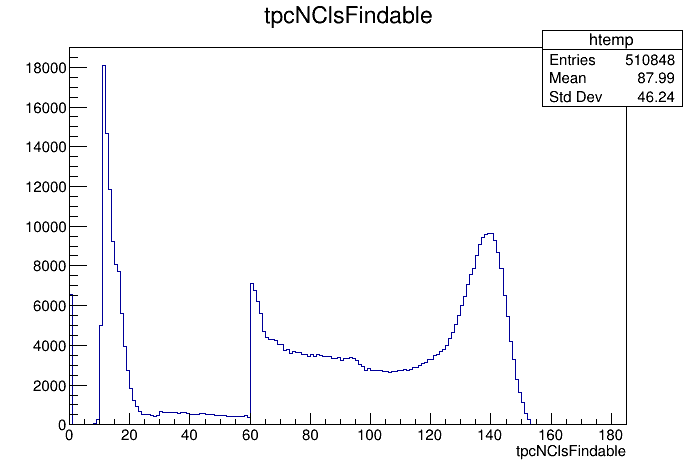

In [10]:
c1=ROOT.TCanvas("c","c")
tracks.SetAlias("itsOn","(flags&0x1)>0")
tracks.Draw("tpcNClsFindable","")
c1.Draw()

In [11]:
tracks.GetLeaf("tpcNClsFindable").Print()
tracks.GetLeaf("tpcNClsFindableMinusFound").Print()

OBJ: TLeafS	tpcNClsFindable	tpcNClsFindable
OBJ: TLeafS	tpcNClsFindableMinusFound	tpcNClsFindableMinusFound


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


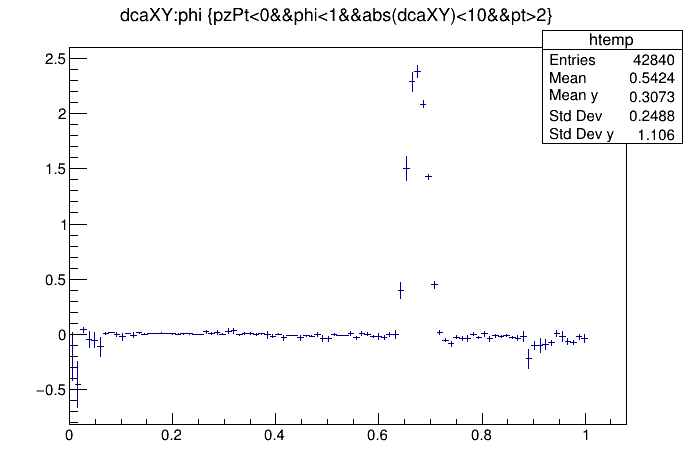

In [12]:
c1=ROOT.TCanvas("c","c")
tracks.SetAlias("itsOn","(flags&0x1)>0")
tracks.Draw("dcaXY:phi","pzPt<0&&phi<1&&abs(dcaXY)<10&&pt>2","prof")
c1.Draw()